In [1]:
# 畳み込みニューラルネットワークを利用した画像認識

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add, Input, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from io import StringIO
import re

In [2]:
# データセット前処理 (正規化など)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 各画素を0から1に正規化
X_train = x_train.astype('float32') / 255     
X_test = x_test.astype('float32') /255

# 出力形式を変換 (6 ⇒ [0,0,0,0,0,0,1,0,0,0] に)
Y_train = y_train.reshape(-1)
Y_test = y_test.reshape(-1)

print(y_train)
# Y_train = utils.to_categorical(y_train, 10)
# Y_test = utils.to_categorical(y_test, 10)
print(Y_train)

print('X_train shape:', X_train.shape)      # X_trainの配列形状
print('Y_train shape:', Y_train.shape)      # Y_trainの配列形状

print('X_testr shape:', X_test.shape)      # X_trainの配列形状
print('Y_test shape:', Y_test.shape)      # Y_trainの配列形状
print(X_train.shape[0], 'train samples')    # 訓練サンプル数
print(X_test.shape[0], 'test samples')      # 評価サンプル数
print(Y_test[1])

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
[6 9 9 ... 9 1 1]
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000,)
X_testr shape: (10000, 32, 32, 3)
Y_test shape: (10000,)
50000 train samples
10000 test samples
8


[4]
4


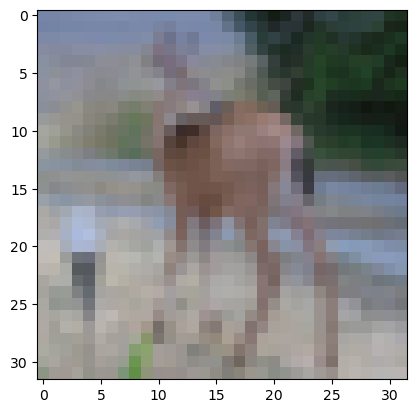

In [3]:
# 元
plt.imshow(X_test[100])    # 入力画像の例を表示
print(y_test[100])     # 正解データ (ラベル)
print(Y_test[100])     # 正解データ (確率の配列)

In [4]:
# Data augmentation

class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, cutout_mask_size = 0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cutout_mask_size = cutout_mask_size
        
    def cutout(self, x, y):
        return np.array(list(map(self._cutout, x))), y
    
    def _cutout(self, image_origin):
        # 最後に使うfill()は元の画像を書き換えるので、コピーしておく
        image = np.copy(image_origin)
        mask_value = image.mean()

        h, w, _ = image.shape
        # マスクをかける場所のtop, leftをランダムに決める
        # はみ出すことを許すので、0以上ではなく負の値もとる(最大mask_size // 2はみ出す)
        top = np.random.randint(0 - self.cutout_mask_size // 2, h - self.cutout_mask_size)
        left = np.random.randint(0 - self.cutout_mask_size // 2, w - self.cutout_mask_size)
        bottom = top + self.cutout_mask_size
        right = left + self.cutout_mask_size

        # はみ出した場合の処理
        if top < 0:
            top = 0
        if left < 0:
            left = 0

        # マスク部分の画素値を平均値で埋める
        image[top:bottom, left:right, :].fill(mask_value)
        return image
    
    def flow(self, *args, **kwargs):
        batches = super().flow(*args, **kwargs)
        
        # 拡張処理
        while True:
            batch_x, batch_y = next(batches)
            
            if self.cutout_mask_size > 0:
                result = self.cutout(batch_x, batch_y)
                batch_x, batch_y = result                        
                
            yield (batch_x, batch_y)     

datagen_parameters = {"horizontal_flip": True, "width_shift_range": 0.1, "height_shift_range": 0.1, "cutout_mask_size": 16}
datagen = CustomImageDataGenerator(**datagen_parameters)
datagen_for_test = ImageDataGenerator()
# ZCA whiteningなどを行う場合が以下の実行が必要
# datagen.fit(train_x)
# datagen_for_test.fit(test_x)


In [5]:
# define model

n = 9 # 56 layers
channels = [16, 32, 64]

inputs = Input(shape=(32, 32, 3))
x = Conv2D(channels[0], kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation(tf.nn.relu)(x)

for c in channels:
    for i in range(n):
        subsampling = i == 0 and c > 16
        strides = (2, 2) if subsampling else (1, 1)
        y = Conv2D(c, kernel_size=(3, 3), padding="same", strides=strides, kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation(tf.nn.relu)(y)
        y = Conv2D(c, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)        
        if subsampling:
            x = Conv2D(c, kernel_size=(1, 1), strides=(2, 2), padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(x)
        x = Add()([x, y])
        x = Activation(tf.nn.relu)(x)

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
outputs = Dense(10, activation=tf.nn.softmax, kernel_initializer="he_normal")(x)

model = Model(inputs=inputs, outputs=outputs)
model.type = "resnet" + str(6 * n + 2)
     
with StringIO() as buf:
    model.summary(print_fn=lambda x: buf.write(x + "\n"))
    summary = buf.getvalue()
print(summary)
re1 = re.match(r"(.|\s)*Total params: ", summary)
re2 = re.match(r"(.|\s)*Total params: [\d|,]+", summary)
total_params = summary[re1.end():re2.end()]

2023-04-23 16:03:28.255235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 16:03:28.262135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 16:03:28.262277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 16:03:28.262884: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# prepare training 

# lr = 0.001
# optimizer = Adam(learning_rate=lr)
lr = 0.1
optimizer = SGD(learning_rate=lr, momentum=0.9)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#train
num_epoch =10
learn_minute = 120
batch_size = 64


history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    batch_size = 64,
                    epochs=num_epoch, 
                    validation_data=datagen_for_test.flow(X_test, Y_test, batch_size=batch_size))

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2023-04-23 16:03:29.453151: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-04-23 16:03:33.124733: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 7605


  11200/Unknown - 974s 87ms/step - loss: 1.7863 - accuracy: 0.4800

In [ ]:

# 学習誤差グラフ
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.title('Loss')
plt.legend()
plt.xlabel('epoch')
plt.yscale('log')
plt.savefig("epoch-10-resnet-56-loss-data-aug.png")
plt.show()

# 学習精度グラフ
plt.plot(history.history['accuracy'], label="acc")
plt.plot(history.history['val_accuracy'], label="val_acc")
plt.title('Accuracy')
plt.legend(loc="lower right")
plt.xlabel('epoch')
plt.savefig("epoch-10-resnet-56-accuracy-data-aug.png")
plt.show()

